In [41]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 1000


# Identification part of the filenames
base_name = 'HighDynamicRange2'
base_dir = '/path/to/base/directory'   # Set base directory

## Train Transformer on dataset of 44 metabolites

In [46]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = f"Transformer_44met_{base_name}Dist_TrainingAndValidation_ForManuscript_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir(base_dir+'/DL-NMR-Optimization/ModelPerformanceMetrics/') 
seed = 1
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [43]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra = np.load(f'Dataset44_{base_name}_ForManuscript_Spec.npy')
conc1 = np.load(f'Dataset44_{base_name}_ForManuscript_Conc.npy')

In [4]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [5]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra, conc1, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
#spectraVal = torch.tensor(spectraVal).float().to(device)   # Confusing names, these spectra are the 5000 spectra generated like the training dataset
#ValSpectra = torch.tensor(ValSpectra).float().to(device)   # Confusing names, these spectra are the 10 representative example spectra

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
#concVal = torch.tensor(concVal).float().to(device)
#ValConc = torch.tensor(ValConc).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(datasets, batch_size = 76, shuffle=True)
test_iter = torch.utils.data.DataLoader(Test_datasets, batch_size = 76, shuffle=True)

In [6]:
del X_train
del X_test
del y_train
del y_test
del spectra
del conc1
del datasets
del Test_datasets

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(23552, 44)

    def forward(self, x):
        # Binning
        batch_size, seq_length = x.size()
        num_bins = seq_length // self.input_dim
        x = x.view(batch_size, num_bins, self.input_dim)  # (batch_size, num_bins, input_dim)
        
        # Embedding
        x = self.embedding(x)  # (batch_size, num_bins, d_model)
        
        # Add positional encoding
        x = self.positional_encoding(x)
        
        # Transformer Encoder
        x = x.permute(1, 0, 2)  # (num_bins, batch_size, d_model)
        x = self.transformer_encoder(x)  # (num_bins, batch_size, d_model)
        x = x.permute(1, 0, 2)  # (batch_size, num_bins, d_model)
        
        # Reconstruct original sequence
        x = x.reshape(batch_size, num_bins * d_model)
        
        # Decoding
        x = self.decoder(x)  # (batch_size, output_dim)
        
        return x

# Parameters
input_dim = 1000  # Size of each bin
d_model = 512     # Embedding dimension
nhead = 1         # Number of attention heads
num_encoder_layers = 1  # Number of transformer encoder layers
dim_feedforward = 2048  # Feedforward dimension
dropout = 0.0     # Dropout rate


In [8]:
class RelativeAbsoluteError(nn.Module):
    def __init__(self):
        super(RelativeAbsoluteError, self).__init__()

    def forward(self, y_pred, y_true):
        # Compute the mean of the true values
        y_mean = torch.mean(y_true)
        
        # Compute the absolute differences
        absolute_errors = torch.abs(y_true - y_pred)
        mean_absolute_errors = torch.abs(y_true - y_mean)
        
        # Compute RAE
        rae = torch.sum(absolute_errors) / torch.sum(mean_absolute_errors)
        return rae

In [9]:
def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = RelativeAbsoluteError()
    optimizer = optim.AdamW(model.parameters(), lr=0.00014656680844397094, weight_decay=0.01)
    
    
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 50  # Set how many epochs without improvement in validation loss constitutes early stopping

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
            
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
            
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break



    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [10]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Create model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


No pretrained model found. Training from scratch.
Epoch [1/1000], Train Loss: 10501.8557, Test Loss: 2585.4413
Epoch [2/1000], Train Loss: 10150.4897, Test Loss: 2511.2569
Epoch [3/1000], Train Loss: 9149.8346, Test Loss: 1641.5062
Epoch [4/1000], Train Loss: 4095.0743, Test Loss: 695.3610
Epoch [5/1000], Train Loss: 2251.6674, Test Loss: 460.6492
Epoch [6/1000], Train Loss: 1571.3350, Test Loss: 334.3962
Epoch [7/1000], Train Loss: 1140.3751, Test Loss: 251.9267
Epoch [8/1000], Train Loss: 922.1794, Test Loss: 217.9319
Epoch [9/1000], Train Loss: 781.6530, Test Loss: 183.3989
Epoch [10/1000], Train Loss: 699.1897, Test Loss: 173.9069
Epoch [11/1000], Train Loss: 632.8801, Test Loss: 159.7620
Epoch [12/1000], Train Loss: 588.0360, Test Loss: 153.3452
Epoch [13/1000], Train Loss: 554.2613, Test Loss: 132.2344
Epoch [14/1000], Train Loss: 524.8564, Test Loss: 132.2475
Epoch [15/1000], Train Loss: 498.4410, Test Loss: 131.1149
Epoch [16/1000], Train Loss: 484.9956, Test Loss: 117.0561
Epo

Epoch [141/1000], Train Loss: 222.6100, Test Loss: 59.1951
Epoch [142/1000], Train Loss: 222.2855, Test Loss: 59.0747
Epoch [143/1000], Train Loss: 220.3989, Test Loss: 59.6880
Epoch [144/1000], Train Loss: 217.7723, Test Loss: 54.7973
Epoch [145/1000], Train Loss: 216.5547, Test Loss: 59.3361
Epoch [146/1000], Train Loss: 217.4334, Test Loss: 57.7833
Epoch [147/1000], Train Loss: 218.1837, Test Loss: 55.8120
Epoch [148/1000], Train Loss: 214.3038, Test Loss: 56.5190
Epoch [149/1000], Train Loss: 214.8963, Test Loss: 63.5426
Epoch [150/1000], Train Loss: 215.9040, Test Loss: 57.2215
Epoch [151/1000], Train Loss: 216.0155, Test Loss: 55.6875
Epoch [152/1000], Train Loss: 212.5810, Test Loss: 53.6913
Epoch [153/1000], Train Loss: 212.4887, Test Loss: 54.7886
Epoch [154/1000], Train Loss: 213.6299, Test Loss: 54.0068
Epoch [155/1000], Train Loss: 210.2879, Test Loss: 56.4766
Epoch [156/1000], Train Loss: 211.5550, Test Loss: 54.7824
Epoch [157/1000], Train Loss: 209.5589, Test Loss: 55.67

Epoch [280/1000], Train Loss: 171.6910, Test Loss: 46.9513
Epoch [281/1000], Train Loss: 169.4761, Test Loss: 43.5995
Epoch [282/1000], Train Loss: 169.8469, Test Loss: 46.5238
Epoch [283/1000], Train Loss: 166.4384, Test Loss: 42.5885
Epoch [284/1000], Train Loss: 170.7379, Test Loss: 44.8169
Epoch [285/1000], Train Loss: 169.7604, Test Loss: 44.2851
Epoch [286/1000], Train Loss: 169.5426, Test Loss: 44.9197
Epoch [287/1000], Train Loss: 169.8017, Test Loss: 47.6769
Epoch [288/1000], Train Loss: 170.0484, Test Loss: 48.7899
Epoch [289/1000], Train Loss: 169.5990, Test Loss: 45.1815
Epoch [290/1000], Train Loss: 167.0647, Test Loss: 44.2602
Epoch [291/1000], Train Loss: 169.5306, Test Loss: 44.8287
Epoch [292/1000], Train Loss: 167.1679, Test Loss: 44.3276
Epoch [293/1000], Train Loss: 167.7130, Test Loss: 44.7391
Epoch [294/1000], Train Loss: 166.3780, Test Loss: 50.2341
Epoch [295/1000], Train Loss: 169.7073, Test Loss: 43.7956
Epoch [296/1000], Train Loss: 172.1546, Test Loss: 45.29

Epoch [419/1000], Train Loss: 152.3444, Test Loss: 41.0779
Epoch [420/1000], Train Loss: 152.0222, Test Loss: 41.9531
Epoch [421/1000], Train Loss: 148.6961, Test Loss: 40.0847
Epoch [422/1000], Train Loss: 152.2861, Test Loss: 40.7354
Epoch [423/1000], Train Loss: 150.4607, Test Loss: 39.7576
Epoch [424/1000], Train Loss: 150.9158, Test Loss: 40.6270
Epoch [425/1000], Train Loss: 148.9987, Test Loss: 42.8681
Epoch [426/1000], Train Loss: 148.7993, Test Loss: 42.4106
Epoch [427/1000], Train Loss: 150.2935, Test Loss: 39.9434
Epoch [428/1000], Train Loss: 150.5220, Test Loss: 43.1089
Epoch [429/1000], Train Loss: 149.4777, Test Loss: 43.7361
Epoch [430/1000], Train Loss: 150.2409, Test Loss: 39.1777
Epoch [431/1000], Train Loss: 147.7757, Test Loss: 39.4532
Epoch [432/1000], Train Loss: 148.3669, Test Loss: 40.9254
Epoch [433/1000], Train Loss: 151.2315, Test Loss: 39.9558
Epoch [434/1000], Train Loss: 149.8290, Test Loss: 39.5455
Epoch [435/1000], Train Loss: 149.3037, Test Loss: 41.58

Epoch [558/1000], Train Loss: 139.6640, Test Loss: 38.1457
Epoch [559/1000], Train Loss: 139.3848, Test Loss: 37.6519
Epoch [560/1000], Train Loss: 139.5988, Test Loss: 37.5748
Epoch [561/1000], Train Loss: 138.2866, Test Loss: 37.7271
Epoch [562/1000], Train Loss: 137.9029, Test Loss: 36.7995
Epoch [563/1000], Train Loss: 138.2931, Test Loss: 38.0906
Epoch [564/1000], Train Loss: 139.2843, Test Loss: 37.7457
Epoch [565/1000], Train Loss: 139.6713, Test Loss: 39.9808
Epoch [566/1000], Train Loss: 138.9621, Test Loss: 37.2672
Epoch [567/1000], Train Loss: 138.6864, Test Loss: 38.4541
Epoch [568/1000], Train Loss: 139.4992, Test Loss: 38.1032
Epoch [569/1000], Train Loss: 137.5790, Test Loss: 37.8801
Epoch [570/1000], Train Loss: 139.8302, Test Loss: 42.3348
Epoch [571/1000], Train Loss: 139.6675, Test Loss: 36.6891
Epoch [572/1000], Train Loss: 136.0880, Test Loss: 37.5911
Epoch [573/1000], Train Loss: 135.7482, Test Loss: 37.0296
Epoch [574/1000], Train Loss: 136.1664, Test Loss: 38.77

Epoch [697/1000], Train Loss: 132.2243, Test Loss: 35.7461
Epoch [698/1000], Train Loss: 129.5145, Test Loss: 38.8626
Epoch [699/1000], Train Loss: 131.0446, Test Loss: 36.1460
Epoch [700/1000], Train Loss: 129.0160, Test Loss: 35.5097
Epoch [701/1000], Train Loss: 131.2193, Test Loss: 34.3587
Epoch [702/1000], Train Loss: 131.7922, Test Loss: 37.4176
Epoch [703/1000], Train Loss: 130.8172, Test Loss: 35.4552
Epoch [704/1000], Train Loss: 130.6215, Test Loss: 36.5351
Epoch [705/1000], Train Loss: 127.9235, Test Loss: 34.4522
Epoch [706/1000], Train Loss: 128.1394, Test Loss: 35.8832
Epoch [707/1000], Train Loss: 130.7379, Test Loss: 36.8574
Epoch [708/1000], Train Loss: 131.2741, Test Loss: 38.4487
Epoch [709/1000], Train Loss: 131.1769, Test Loss: 35.2126
Epoch [710/1000], Train Loss: 130.8173, Test Loss: 35.1415
Epoch [711/1000], Train Loss: 133.2927, Test Loss: 38.7629
Epoch [712/1000], Train Loss: 128.6939, Test Loss: 35.2701
Epoch [713/1000], Train Loss: 127.8668, Test Loss: 34.12

In [11]:
np.array(test_losses).min()

34.12565334327519

In [44]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load validation dataset
spectraVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Spec.npy')
concVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Conc.npy')



# Load representative validation spectra and concentrations
# Load spectra of varied concentrations (all metabolites at X-mM from 0.005mm to 20mM)
ConcSpec = np.load(f'Concentration_44met_{base_name}_ForManuscript_Spec.npy')
ConcConc = np.load(f'Concentration_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load uniform concentration distribution validation spectra
UniformSpec = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Spec.npy')
UniformConc = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load low concentration uniform concentration distribution validation spectra
LowUniformSpec = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Spec.npy')
LowUniformConc = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Conc.npy')
#  Load tissue mimicking concentration distribution validation spectra
MimicTissueRangeSpec = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeConc = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Conc.npy')
#  Load liver tissue mimicking concentration distribution (high relative glucose) validation spectra
MimicTissueRangeGlucSpec = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeGlucConc = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Conc.npy')
#  Load high dynamic range #2 validation spectra
HighDynamicRange2Spec = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Spec.npy')
HighDynamicRange2Conc = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Conc.npy') 
#  Load varied SNR validation spectra
SNR_Spec = np.load(f'SNR_44met_{base_name}_ForManuscript_Spec.npy')
SNR_Conc = np.load(f'SNR_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random singlet validation spectra
Singlet_Spec = np.load(f'Singlet_44met_{base_name}_ForManuscript_Spec.npy')
Singlet_Conc = np.load(f'Singlet_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random qref checker validation spectra
QrefSensSpec = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Spec.npy')
QrefSensConc = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Conc.npy')
#  Load other validation spectra
OtherValSpectra = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Spec.npy')
OtherValConc = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Conc.npy')




# Move the input data to the GPU device
spectraVal = torch.tensor(spectraVal).float().to(device)   
concVal = torch.tensor(concVal).float().to(device)
ConcSpec = torch.tensor(ConcSpec).float().to(device)   
ConcConc = torch.tensor(ConcConc).float().to(device)
UniformSpec = torch.tensor(UniformSpec).float().to(device)   
UniformConc = torch.tensor(UniformConc).float().to(device)
LowUniformSpec = torch.tensor(LowUniformSpec).float().to(device)   
LowUniformConc = torch.tensor(LowUniformConc).float().to(device)
MimicTissueRangeSpec = torch.tensor(MimicTissueRangeSpec).float().to(device)   
MimicTissueRangeConc = torch.tensor(MimicTissueRangeConc).float().to(device)
MimicTissueRangeGlucSpec = torch.tensor(MimicTissueRangeGlucSpec).float().to(device)   
MimicTissueRangeGlucConc = torch.tensor(MimicTissueRangeGlucConc).float().to(device)
HighDynamicRange2Spec = torch.tensor(HighDynamicRange2Spec).float().to(device)   
HighDynamicRange2Conc = torch.tensor(HighDynamicRange2Conc).float().to(device)
SNR_Spec = torch.tensor(SNR_Spec).float().to(device)   
SNR_Conc = torch.tensor(SNR_Conc).float().to(device)
Singlet_Spec = torch.tensor(Singlet_Spec).float().to(device)   
Singlet_Conc = torch.tensor(Singlet_Conc).float().to(device)
QrefSensSpec = torch.tensor(QrefSensSpec).float().to(device)   
QrefSensConc = torch.tensor(QrefSensConc).float().to(device)
OtherValSpectra = torch.tensor(OtherValSpectra).float().to(device)   
OtherValConc = torch.tensor(OtherValConc).float().to(device)

In [47]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Load the model's state dictionary from the loaded dictionary
model_aq.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_aq.to(device)

Transformer(
  (embedding): Linear(in_features=1000, out_features=512, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=23552, out_features=44, bias=True)
)

In [48]:
Prediction = model_aq(spectraVal[0].unsqueeze(0))

Prediction

tensor([[ 1.1009e-02,  1.0572e-01,  7.3533e-01,  7.4563e+00,  3.8302e-02,
          6.7521e-02,  4.5678e-02,  3.1216e-01,  1.0235e-01,  1.0122e-01,
          9.3036e-02,  5.5840e-02,  1.0790e-02,  2.9703e-02,  3.2593e-02,
          7.6576e-02,  1.8814e+01,  3.7450e-02, -1.6796e-02,  3.8185e+00,
          4.6687e-01,  3.2561e+00,  1.3121e-01,  8.3181e+00,  5.7763e-01,
          1.5698e+01,  4.3058e-02,  4.1161e-02,  1.9685e-02,  3.7007e-02,
          2.8731e-01,  6.5877e-02,  1.5729e+01,  5.5218e-02,  1.3998e-02,
          1.8640e+01,  2.6541e-01,  1.5146e-01,  1.6123e-01,  3.4829e-02,
          5.6599e-02,  9.4115e-02,  1.8581e+01,  8.0303e-01]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [49]:
Prediction.detach().cpu().numpy()[0]

array([ 1.10086929e-02,  1.05719745e-01,  7.35333800e-01,  7.45633364e+00,
        3.83015461e-02,  6.75213188e-02,  4.56782915e-02,  3.12156945e-01,
        1.02352172e-01,  1.01215079e-01,  9.30361450e-02,  5.58401197e-02,
        1.07900072e-02,  2.97032651e-02,  3.25928219e-02,  7.65756890e-02,
        1.88138046e+01,  3.74500528e-02, -1.67962145e-02,  3.81850123e+00,
        4.66868103e-01,  3.25605917e+00,  1.31213993e-01,  8.31809044e+00,
        5.77631831e-01,  1.56980009e+01,  4.30579223e-02,  4.11608964e-02,
        1.96846873e-02,  3.70071232e-02,  2.87312746e-01,  6.58770278e-02,
        1.57291508e+01,  5.52180670e-02,  1.39980502e-02,  1.86398220e+01,
        2.65414119e-01,  1.51460499e-01,  1.61230057e-01,  3.48289721e-02,
        5.65988645e-02,  9.41146240e-02,  1.85805798e+01,  8.03030133e-01],
      dtype=float32)

In [50]:
## Compute absolute percent error statistics on validation set

APEs = []
MAPEs = []

for i in np.arange(5000):
    GroundTruth = concVal[i].cpu().numpy()  # Move GroundTruth tensor to CPU and convert to NumPy array
    model_aq.eval()
    Prediction = model_aq(spectraVal[i].unsqueeze(0))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()[0]

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ValExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs))



print('Overall MAPE: ',np.array(MAPEs).mean())


Overall MAPE:  83.41398509776174


In [51]:
## Compute absolute percent error statistics on concentration varied validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = ConcConc[i]
    model_aq.eval()
    Prediction = model_aq(ConcSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ConcExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ConcExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Concentrations:",ConcConc[i][0].item())

Overall MAPE:  inf
--------------------
inf  - Concentrations: 0.0
101.15  - Concentrations: 0.004999999888241291
18.17  - Concentrations: 0.02500000037252903
4.69  - Concentrations: 0.10000000149011612
1.4  - Concentrations: 0.25
0.97  - Concentrations: 0.5
0.67  - Concentrations: 1.0
0.63  - Concentrations: 2.5
0.55  - Concentrations: 10.0
6.76  - Concentrations: 20.0


In [52]:
## Compute absolute percent error statistics on uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = UniformConc[i]
    model_aq.eval()
    Prediction = model_aq(UniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "UniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "UniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(UniformConc[i].min().item(),4), " - Mean Value:", np.round(UniformConc[i].mean().item(),1))

Overall MAPE:  2.2522821
--------------------
0.79  - Min Value: 0.6783  - Mean Value: 9.2
11.99  - Min Value: 0.0096  - Mean Value: 10.3
2.13  - Min Value: 0.147  - Mean Value: 10.5
0.88  - Min Value: 0.5572  - Mean Value: 8.5
0.99  - Min Value: 1.3567  - Mean Value: 10.6
0.88  - Min Value: 0.6332  - Mean Value: 10.9
1.73  - Min Value: 0.7017  - Mean Value: 11.0
1.49  - Min Value: 0.3674  - Mean Value: 8.9
0.74  - Min Value: 0.8387  - Mean Value: 9.8
0.9  - Min Value: 1.0913  - Mean Value: 11.1


In [53]:
## Compute absolute percent error statistics on low concentration uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = LowUniformConc[i]
    model_aq.eval()
    Prediction = model_aq(LowUniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "LowUniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "LowUniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(LowUniformConc[i].min().item(),4), " - Mean Value:", np.round(LowUniformConc[i].mean().item(),1))

Overall MAPE:  6.2215466
--------------------
4.82  - Min Value: 0.0111  - Mean Value: 0.1
7.09  - Min Value: 0.0103  - Mean Value: 0.1
5.53  - Min Value: 0.0153  - Mean Value: 0.1
6.19  - Min Value: 0.0117  - Mean Value: 0.1
5.92  - Min Value: 0.0089  - Mean Value: 0.1
7.33  - Min Value: 0.0075  - Mean Value: 0.1
5.71  - Min Value: 0.0117  - Mean Value: 0.1
9.75  - Min Value: 0.0052  - Mean Value: 0.1
6.38  - Min Value: 0.008  - Mean Value: 0.1
3.49  - Min Value: 0.0134  - Mean Value: 0.1


In [54]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeConc[i].mean().item(),1))

Overall MAPE:  8.320032
--------------------
14.61  - Min Value: 0.008  - Mean Value: 0.8
11.07  - Min Value: 0.009  - Mean Value: 0.9
10.49  - Min Value: 0.0138  - Mean Value: 1.5
6.11  - Min Value: 0.0107  - Mean Value: 0.7
5.89  - Min Value: 0.0191  - Mean Value: 0.7
11.85  - Min Value: 0.0186  - Mean Value: 0.8
5.17  - Min Value: 0.0175  - Mean Value: 0.8
5.29  - Min Value: 0.0238  - Mean Value: 1.3
5.71  - Min Value: 0.0168  - Mean Value: 0.7
7.01  - Min Value: 0.0171  - Mean Value: 0.9


In [55]:
APEs[0]

[tensor(1.0014),
 tensor(20.3926),
 tensor(0.4330),
 tensor(35.0753),
 tensor(40.1250),
 tensor(3.9866),
 tensor(182.0647),
 tensor(0.1058),
 tensor(19.0988),
 tensor(0.8674),
 tensor(0.6988),
 tensor(127.4391),
 tensor(0.2921),
 tensor(0.4198),
 tensor(7.6783),
 tensor(4.0909),
 tensor(0.9306),
 tensor(6.5451),
 tensor(1.0969),
 tensor(17.9247),
 tensor(17.7305),
 tensor(0.4254),
 tensor(4.5098),
 tensor(16.9327),
 tensor(0.0331),
 tensor(0.8029),
 tensor(10.5348),
 tensor(0.4016),
 tensor(0.9337),
 tensor(51.0787),
 tensor(0.7071),
 tensor(3.1271),
 tensor(4.6177),
 tensor(1.5129),
 tensor(6.4142),
 tensor(22.5907),
 tensor(1.1651),
 tensor(0.4504),
 tensor(0.2414),
 tensor(14.7519),
 tensor(0.8623),
 tensor(0.7058),
 tensor(1.3136),
 tensor(10.8317)]

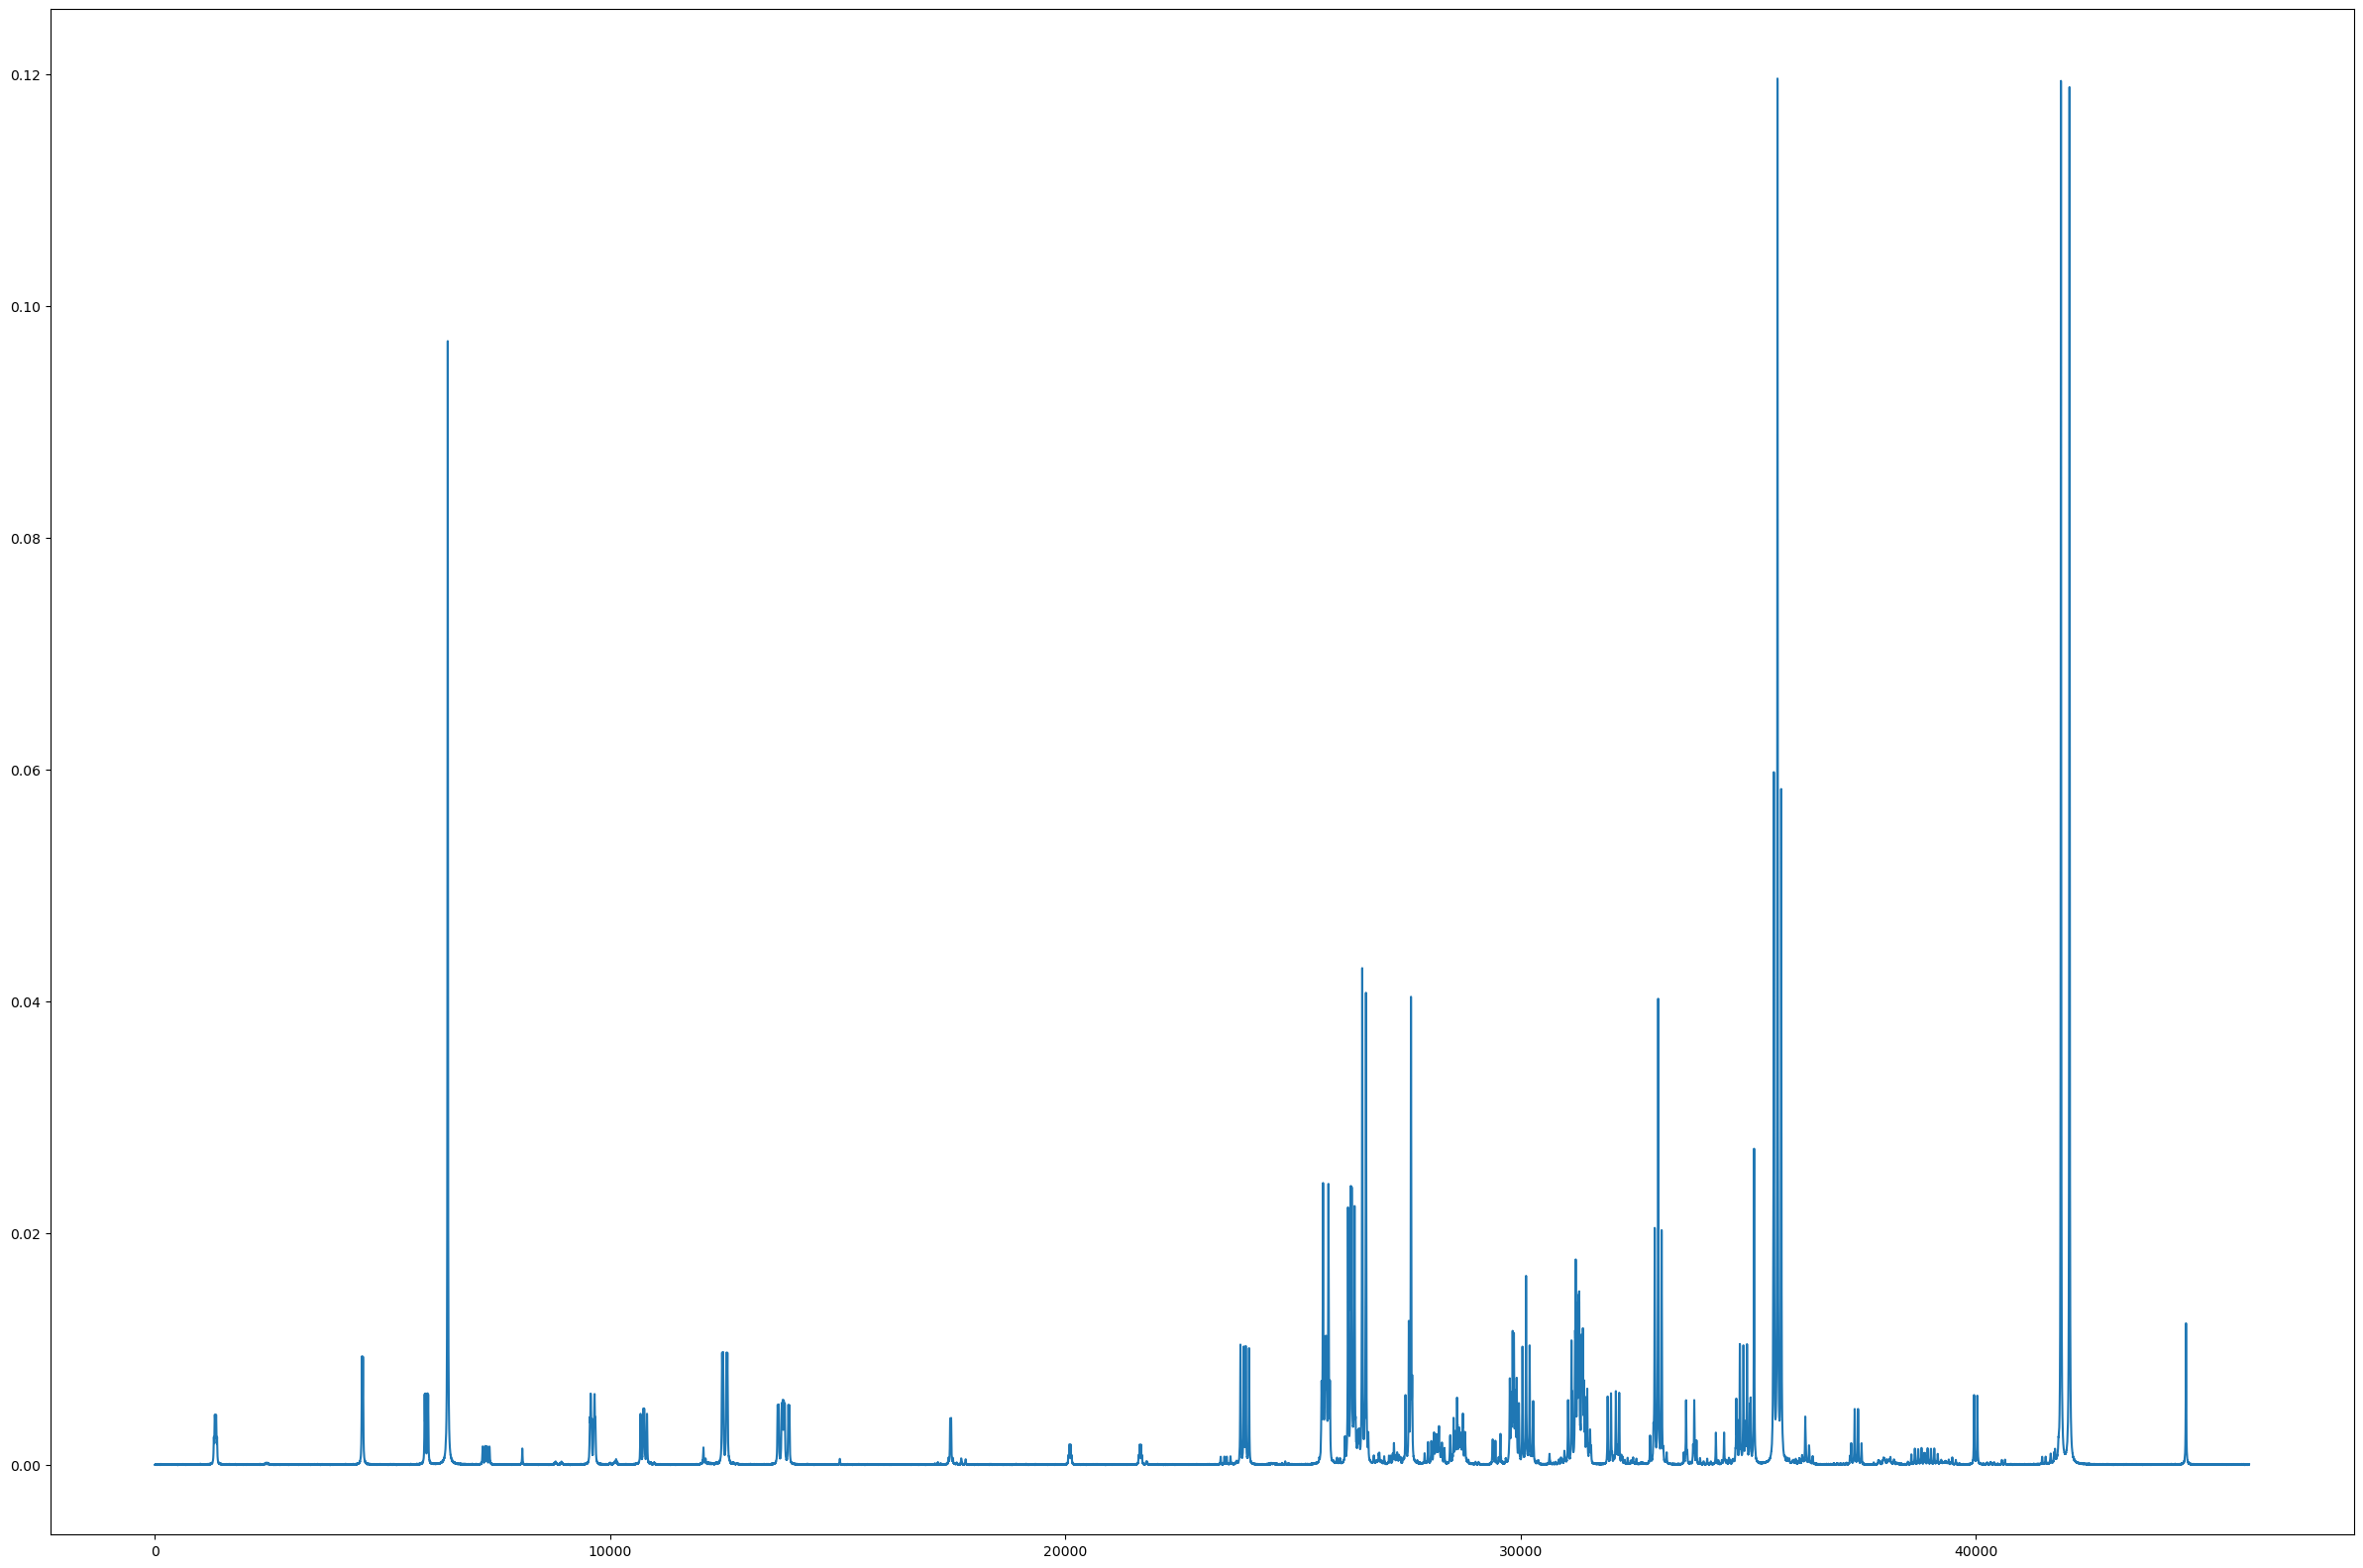

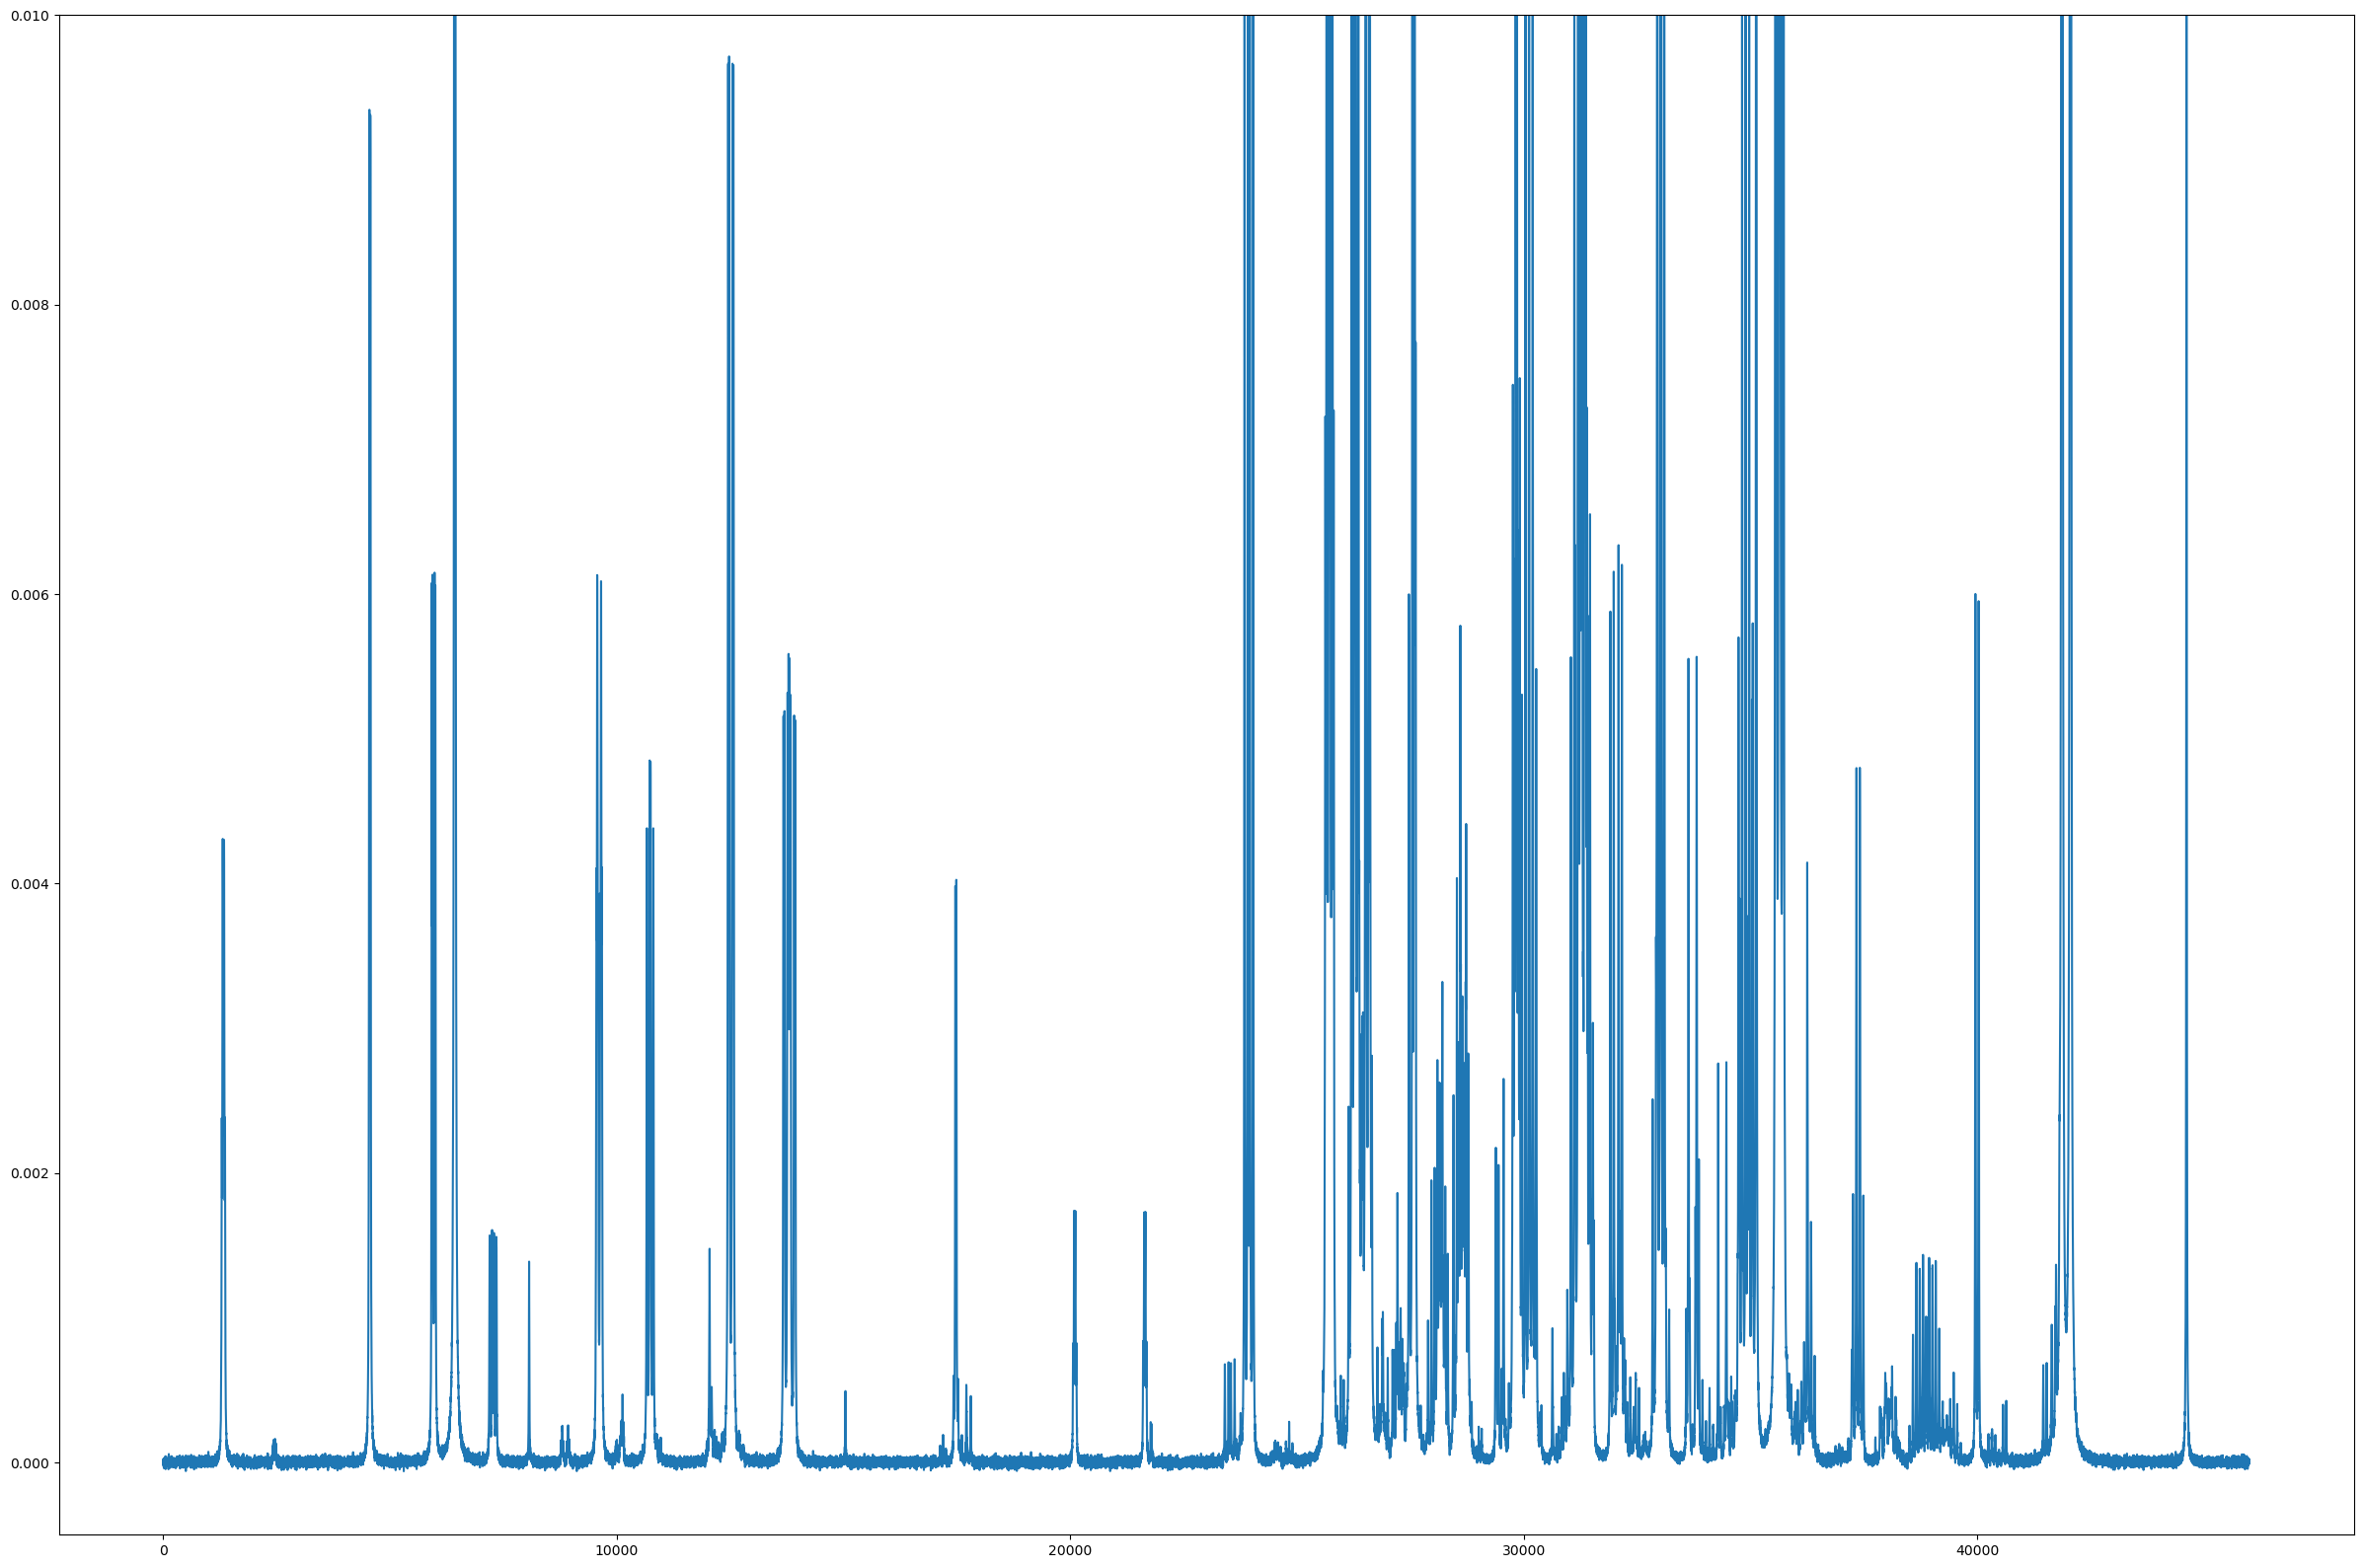

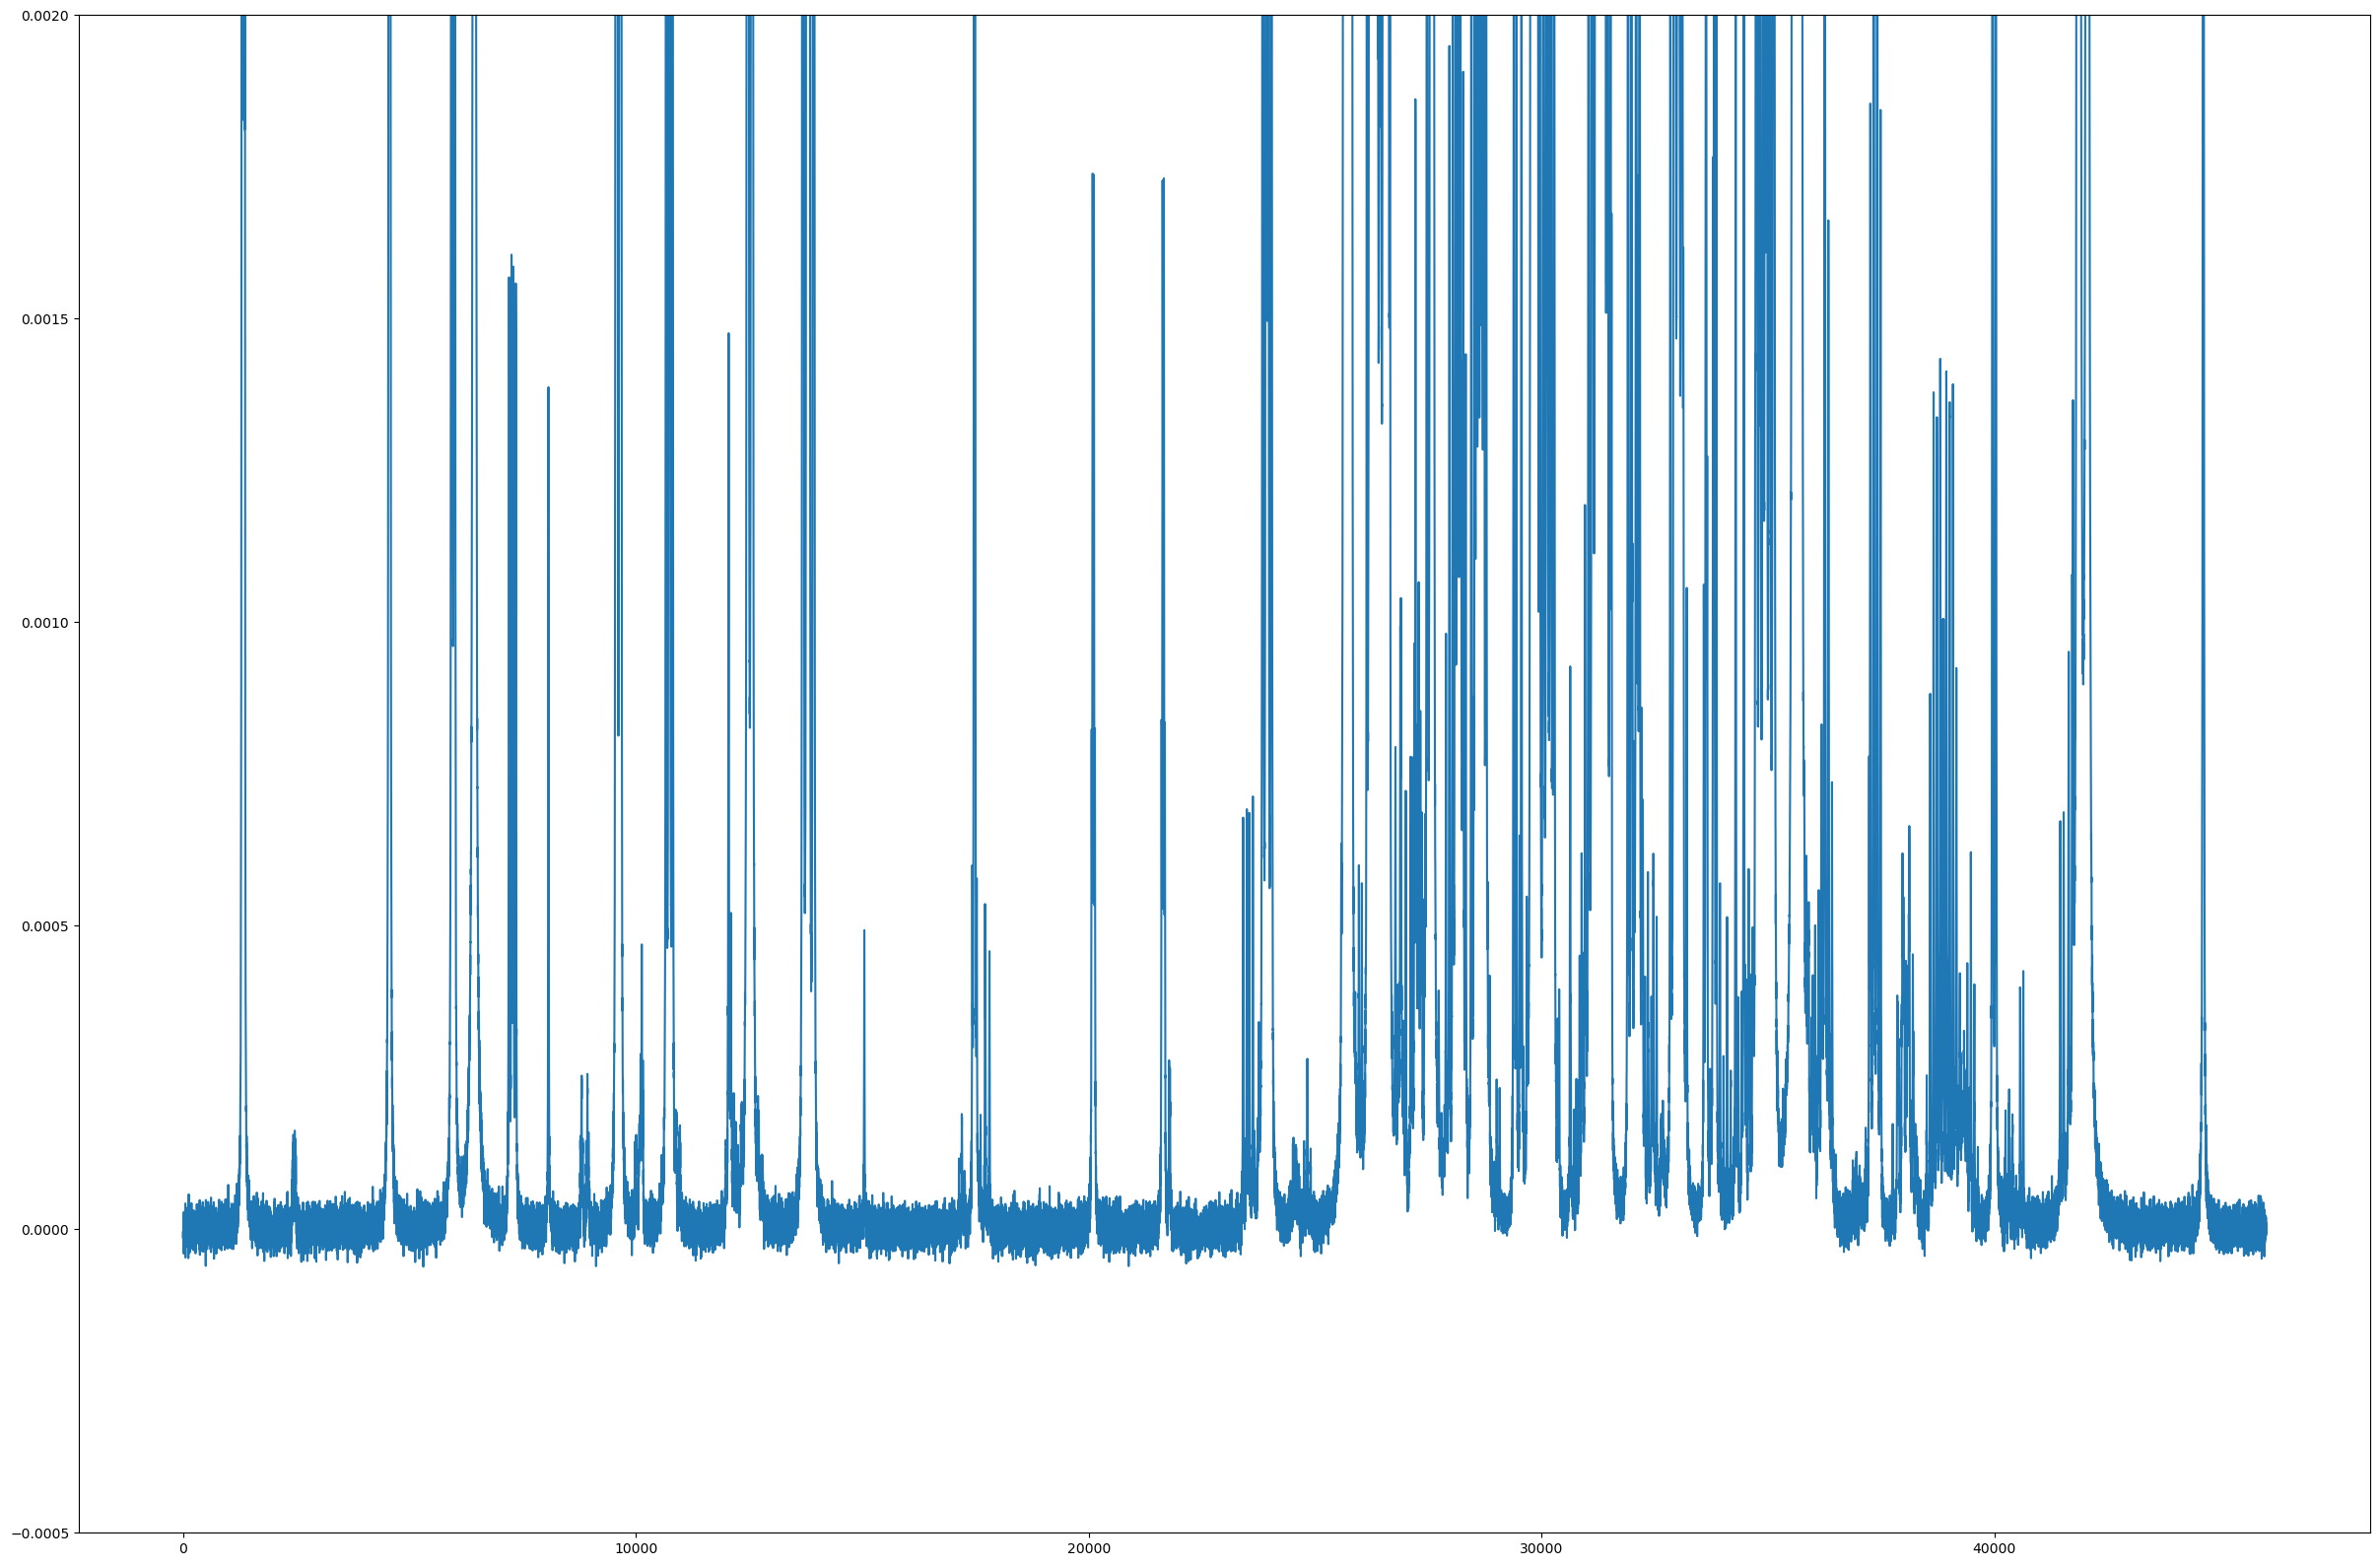

In [56]:
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.01)
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.002)
plt.show()

In [57]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra (high relative glucose concentration)

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeGlucConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeGlucSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeGlucConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeGlucConc[i].mean().item(),1))

Overall MAPE:  13.033213
--------------------
11.01  - Min Value: 0.013  - Mean Value: 0.6
13.82  - Min Value: 0.0115  - Mean Value: 0.4
15.83  - Min Value: 0.0115  - Mean Value: 0.4
12.06  - Min Value: 0.0115  - Mean Value: 0.6
11.5  - Min Value: 0.0115  - Mean Value: 1.0
12.85  - Min Value: 0.0115  - Mean Value: 1.1
20.82  - Min Value: 0.0115  - Mean Value: 0.8
7.74  - Min Value: 0.0115  - Mean Value: 0.5
6.62  - Min Value: 0.0115  - Mean Value: 0.5
18.08  - Min Value: 0.0115  - Mean Value: 1.1


In [58]:
## Compute absolute percent error statistics on a further high dynamic range dataset

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = HighDynamicRange2Conc[i]
    model_aq.eval()
    Prediction = model_aq(HighDynamicRange2Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "HighDynamicRange2Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "HighDynamicRange2Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(HighDynamicRange2Conc[i].min().item(),4), " - Mean Value:", np.round(HighDynamicRange2Conc[i].mean().item(),1))

Overall MAPE:  61.47224
--------------------
52.18  - Min Value: 0.0062  - Mean Value: 2.1
54.67  - Min Value: 0.006  - Mean Value: 3.7
56.25  - Min Value: 0.0066  - Mean Value: 4.3
69.17  - Min Value: 0.0094  - Mean Value: 4.3
67.85  - Min Value: 0.0068  - Mean Value: 4.9
80.65  - Min Value: 0.005  - Mean Value: 3.8
72.18  - Min Value: 0.0101  - Mean Value: 3.2
28.84  - Min Value: 0.0062  - Mean Value: 3.2
53.71  - Min Value: 0.0053  - Mean Value: 5.3
79.22  - Min Value: 0.0054  - Mean Value: 2.5


In [59]:
ConcConc[5]

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       device='cuda:0')

In [60]:
model_aq(ConcSpec[5])

tensor([[0.5032, 0.4899, 0.4991, 0.4980, 0.5086, 0.5047, 0.5052, 0.5041, 0.5069,
         0.5076, 0.5011, 0.4914, 0.5025, 0.4962, 0.4852, 0.5033, 0.5040, 0.5044,
         0.4981, 0.5058, 0.5005, 0.5037, 0.5051, 0.4922, 0.4939, 0.5006, 0.4968,
         0.4989, 0.5079, 0.5063, 0.4989, 0.4984, 0.5053, 0.5016, 0.5040, 0.5064,
         0.4940, 0.4946, 0.5096, 0.5033, 0.5031, 0.5087, 0.5080, 0.5037]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [61]:
model_aq(SNR_Spec[1])

tensor([[0.4316, 0.4234, 0.4259, 0.4259, 0.4378, 0.4315, 0.4359, 0.4308, 0.4364,
         0.4370, 0.4307, 0.4218, 0.4340, 0.4255, 0.4269, 0.4315, 0.4344, 0.4351,
         0.4297, 0.4352, 0.4300, 0.4361, 0.4288, 0.4228, 0.4217, 0.4316, 0.4249,
         0.4306, 0.4384, 0.4364, 0.4281, 0.4261, 0.4381, 0.4308, 0.4336, 0.4343,
         0.4273, 0.4330, 0.4350, 0.4338, 0.4301, 0.4385, 0.4363, 0.4307]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [62]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(SNR_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SNR_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SNR_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  1.283499928029849
--------------------
0.9
0.95
0.92
1.05
1.13
1.0
1.74
1.65
1.9
1.59


In [63]:
## Compute absolute percent error statistics on a dataset with singlets added at random

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(Singlet_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SingletExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SingletExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  17.406839361969563
--------------------
1.1
1.33
1.53
5.29
23.33
23.7
23.91
27.43
31.63
34.81


In [64]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(QrefSensSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "QrefSensitivity_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "QrefSensitivity_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  70.38693634401338
--------------------
6.82
23.35
39.3
55.01
70.74
85.33
98.96
106.1
108.98
109.27


In [65]:
Pred = model_aq(OtherValSpectra[0])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 1")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[1])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 2")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[2])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 1 - 0.01s and 20s")
print(Pred[0])

Pred = model_aq(OtherValSpectra[3])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 2 - 0s and 20s")
print(Pred[0])

Sinusoidal Baseline 1
tensor([0.4525, 0.5796, 0.3652, 0.5785, 0.5045, 0.4915, 0.5069, 0.6148, 0.6937,
        0.4182, 0.4223, 0.6585, 0.5674, 0.8506, 0.3580, 0.6628, 0.6167, 0.4702,
        0.4905, 0.4096, 0.4785, 0.8568, 0.3688, 0.5229, 0.5673, 0.4805, 0.5777,
        0.6655, 0.5145, 0.4745, 0.4432, 0.8638, 0.4732, 0.4260, 0.4539, 0.4864,
        0.4792, 0.4714, 0.6994, 0.4019, 0.4080, 0.5184, 0.5727, 0.4530],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
Sinusoidal Baseline 2
tensor([0.3867, 0.5375, 0.1075, 0.6136, 0.4159, 0.4080, 0.4067, 0.2242, 0.4595,
        0.5626, 0.4175, 0.4936, 0.7501, 0.3923, 0.6733, 0.1714, 0.7353, 0.5395,
        0.4615, 0.3643, 0.3587, 0.4179, 0.5770, 0.5168, 0.3743, 0.4546, 0.2400,
        0.0305, 0.5363, 0.4044, 0.4213, 0.3243, 0.3516, 0.4509, 0.5380, 0.4575,
        0.5908, 0.7576, 0.5505, 0.3623, 0.4519, 0.7637, 0.2920, 0.2152],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
HD-Range 1 - 0.01s a